# Raw data quality control

This notebook evaluates raw station data for the quality issues of duplicate stations, missing names, and spurious spikes/dips in the data. 

Instead of encapsulating these tasks in a pipeline script, this script is designed to be called from the pipeline to 

1) render a human-readable and reproducible document that describes the initial quality control steps taken  
2) produce ancillary data for both pipeline and app ingest to implement quality control steps.

## Duplicate / nearby stations

One issue that we have seen is the possibility of duplicate stations. Check for unusually small distances between airports and investigate.

In [1]:
import os, glob, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.signal import find_peaks

base_dir = Path(os.getenv("BASE_DIR"))
airport_meta = pd.read_csv(base_dir.joinpath("airport_meta.csv"))

# compute pairwise distances between all sites (rows), populate
# data frame with correct sids
coordinates = airport_meta[["sid", "lat", "lon"]].set_index("sid").drop_duplicates()
dists = pdist(coordinates.values)
ij_list = list(itertools.combinations(np.arange(coordinates.index.size), 2))
idx1 = np.array([ij[0] for ij in ij_list])
idx2 = np.array([ij[1] for ij in ij_list])
dist_df = pd.DataFrame({
    "sid1": coordinates.index[idx1], 
    "sid2": coordinates.index[idx2], 
    "dist": dists
})
# same site comparison is artifact of distance computation
dist_df = dist_df[dist_df["sid1"] != dist_df["sid2"]]
# ignore large distances
dist_df = dist_df[dist_df["dist"] < 0.1].sort_values("dist")

Here are the closest stations provided by the IEM ASOS station metadata: 

In [4]:
display(HTML(dist_df.to_html(index=False)))

sid1,sid2,dist
PADG,PARD,0.003936
PACE,PARL,0.005284
PAFL,PAFK,0.015772
PAHL,PAHS,0.032012
PANC,PALH,0.061644
PAED,PAMR,0.061685
PANT,PAMM,0.088449


Some of these are indeed separate airports that are just close:
* PANT (Annette Island Airport), PAMM (Metlaktla Seaplane Base)
* PAED (Elmendorf AFB), PAMR (Merrill Field)
* PANC (Ted Stevens Anchorage International), PALH (Lake Hood Seaplane Base)

The others require investigation:

#### PAHL, PAHS

Here are the metadata entries for these:

In [5]:
display(HTML(airport_meta[airport_meta["sid"].isin(["PAHL", "PAHS"])].to_html(index=False)))

sid,station_name,lat,lon,elev,begints,rw_name,rw_heading,faa_id,real_name
PAHL,Huslia,65.69786,-156.35139,67.0,1999-01-31 22:20:00-06,Runway 3/21,51.0,HLA,Huslia Airport
PAHS,HUSLIA,65.70000,-156.38333,55.0,1994-01-02 20:00:00-06,NaN,NaN,NaN,NaN


AirNav.com didn't have any entry for PAHS. Explore the extent of data for each by plotting the monthly averages over time:

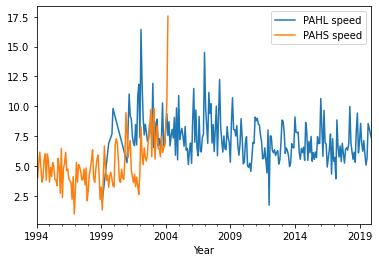

In [6]:
raw_dir = base_dir.joinpath("raw/iem")
pahl = pd.read_csv(list(raw_dir.glob("*PAHL*"))[0], na_values="M")
pahs = pd.read_csv(list(raw_dir.glob("*PAHS*"))[0], na_values="M")

df = pahl.merge(pahs, "outer", ["valid", "station"]).rename(columns={"sped_x": "PAHL speed", "sped_y": "PAHS speed"})
df["valid"] = pd.to_datetime(df["valid"].values)
df["my"] = df["valid"].dt.to_period('M')

df.groupby(["station", "my"]).mean().reset_index().plot(x="my", y=["PAHL speed", "PAHS speed"], xlabel="Year")
plt.show()

So, PAHS had an earlier start, but the time series do not match, so this is likely not from the exact same location. Consider them separately for further analysis. Since PAHS doesn't have enough data to include in the app under current requirements, just exclude this ID from further processing. 

In [7]:
discard = []
discard.append("PAHS")

#### PAFL, PAFK

Metadata entries:

In [8]:
display(HTML(airport_meta[airport_meta["sid"].isin(["PAFL", "PAFK"])].to_html(index=False)))

sid,station_name,lat,lon,elev,begints,rw_name,rw_heading,faa_id,real_name
PAFL,Farewell,62.5316,-153.6111,395.0,2015-04-04 21:47:00-05,Runway 13/31,NaN,TNW,Tin Creek Airport
PAFK,FAREWELL LAKE SEAPLANE,62.5425,-153.6225,321.0,1948-07-01 05:00:00-05,Runway NW/SE,NaN,FKK,Farewell Lake Seaplane Base


External investigation reveals these are just near each other, one being a seaplane base and the other being a typical airport. Ignore for now.

#### PACE, PARL

Metadata entries:

In [9]:
display(HTML(airport_meta[airport_meta["sid"].isin(["PACE", "PARL"])].to_html(index=False)))

sid,station_name,lat,lon,elev,begints,rw_name,rw_heading,faa_id,real_name
PACE,Central,65.57394,-144.78089,286.0,1948-07-01 07:00:00-05,Runway 8/26,103.0,CEM,Central Airport
PARL,CENTRAL AIRPORT,65.57100,-144.77650,284.0,1948-07-01 07:00:00-05,NaN,NaN,NaN,NaN


Both of these are in Central, AK and are very close. Examine time series:

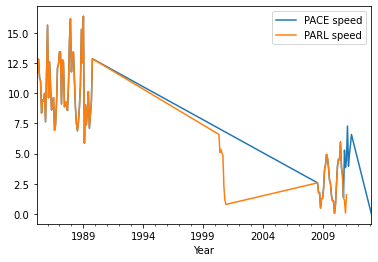

In [10]:
pace = pd.read_csv(list(raw_dir.glob("*PACE*"))[0], na_values="M")
parl = pd.read_csv(list(raw_dir.glob("*PARL*"))[0], na_values="M")

df = pace.merge(parl, "outer", ["valid", "station"]).rename(columns={"sped_x": "PACE speed", "sped_y": "PARL speed"})
df["valid"] = pd.to_datetime(df["valid"].values)
df["my"] = df["valid"].dt.to_period('M')

df.groupby(["station", "my"]).mean().reset_index().plot(x="my", y=["PACE speed", "PARL speed"], xlabel="Year")
plt.show()

These appear to be the same station, with some significant missing data in the 90s/00s. Probably not even worth keeping, as the data aren't even current. Discard both.

In [11]:
discard += ["PACE", "PARL"]

#### PADG, PARD

Metadata entries:

In [12]:
display(HTML(airport_meta[airport_meta["sid"].isin(["PADG", "PARD"])].to_html(index=False)))

sid,station_name,lat,lon,elev,begints,rw_name,rw_heading,faa_id,real_name
PADG,Red Dog,68.03211,-162.89919,295.40000,2007-12-01 10:14:00-06,Runway 3/21,42.0,DGG,Red Dog Airport
PARD,RED DOG,68.03139,-162.90306,288.97864,2010-09-07 19:46:00-05,NaN,NaN,NaN,NaN


These are likely just wrong names for the same station. Time series:

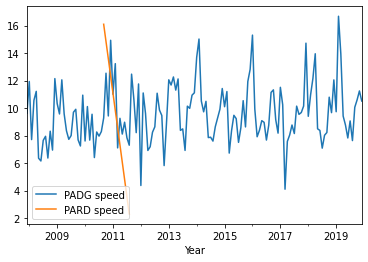

In [13]:
padg = pd.read_csv(list(raw_dir.glob("*PADG*"))[0], na_values="M")
pard = pd.read_csv(list(raw_dir.glob("*PARD*"))[0], na_values="M")

df = padg.merge(pard, "outer", ["valid", "station"]).rename(columns={"sped_x": "PADG speed", "sped_y": "PARD speed"})
df["valid"] = pd.to_datetime(df["valid"].values)
df["my"] = df["valid"].dt.to_period('M')

df.groupby(["station", "my"]).mean().reset_index().plot(x="my", y=["PADG speed", "PARD speed"], xlabel="Year")
plt.show()

Okay, PADG has all the data, looks like PARD is an erroneous station, discard. Save tabular info about these stations for preprocessing.

In [14]:
discard.append("PARD")

## Missing names

Check the airport metadata for missing "real_name" field. This corresponds to stations that were not found on AirNav.com. 

In [15]:
airport_meta = airport_meta.loc[~(airport_meta["sid"].isin(discard))]
airport_meta.loc[pd.isnull(airport_meta["real_name"])]

,sid,station_name,lat,lon,elev,begints,rw_name,rw_heading,faa_id,real_name
25,PALV,BIG RIVER LAKE,60.81600,-152.30200,12.0,1978-08-22 23:00:00-05,NaN,NaN,NaN,NaN
40,PAEC,CHULITNA,62.88333,-149.83333,381.0,1978-11-29 18:00:00-06,NaN,NaN,NaN,NaN
60,PAZK,EUREKA,61.93700,-147.16900,1002.0,1994-12-31 18:00:00-06,NaN,NaN,NaN,NaN
83,PAHZ,HAYES RIVER,61.98300,-152.08600,305.0,1972-12-31 18:00:00-06,NaN,NaN,NaN,NaN
141,PAER,MERRILL PASS WEST,61.25000,-153.82000,358.0,1973-08-25 11:00:00-05,NaN,NaN,NaN,NaN
177,PATO,PORTAGE GLACIER CENTER (ASOS),60.78500,-148.83889,29.0,1998-11-01 03:53:00-06,NaN,NaN,NaN,NaN
184,PAPT,PUNTILLA (LAKE),62.10000,-152.75000,560.0,1972-12-31 19:00:00-06,NaN,NaN,NaN,NaN
214,PALK,SNOWSHOE LAKE,62.03333,-142.66666,735.0,1972-12-31 18:00:00-06,NaN,NaN,NaN,NaN
222,PAJV,SUTTON,61.71667,-148.88333,265.0,1991-12-31 18:00:00-06,NaN,NaN,NaN,NaN
234,PAVW,VALDEZ,61.13333,-146.35000,10.0,1967-07-02 13:00:00-05,NaN,NaN,NaN,NaN


Check the record lengths for these stations:

In [16]:
miss_sid = airport_meta.loc[pd.isnull(airport_meta["real_name"])]["sid"].values
df = pd.concat([pd.read_csv(list(raw_dir.glob(f"*{sid}*"))[0], na_values="M") for sid in miss_sid])
print(df["station"].value_counts())

PAZK    529993
PAVW    232747
PATO    231195
PALV    118643
PAPT    109147
PAEC    105961
PAHZ     94884
PAJV     53207
PALK     46944
PAER      8168
Name: station, dtype: int64


Discard PAER for insufficient data. The remaining stations will require independent investigation and addition of names and other info.

In [17]:
discard.append("PAER")

#### PALK

This is Snowshoe Lake Airport, a private airport near Glenallen, AK. See [AirNav entry.](https://www.airnav.com/airport/5AK4)

Has two runways, Runway 16/34 and Runway 18W/36W.

In [18]:
new_meta = pd.DataFrame({
    "sid": ["PALK", "PALK"], 
    "rw_name": ["Runway 16/34", "Runway 18W/36W"], 
    "rw_heading": [np.nan, np.nan],
    "faa_id": ["5AK4", "5AK4"],
    "real_name": "Snowshoe Lake Airport", 
})

#### PAJV

This is Jonesville Mine Airport. Looks like it was on AirNav previously? [See this archive link](https://web.archive.org/web/20101004221745/http://www.airnav.com/airport/PAJV). 

In [19]:
# add a month-year column to these stations with missing names
df["valid"] = pd.to_datetime(df["valid"].values)
df["my"] = df["valid"].dt.to_period('M')

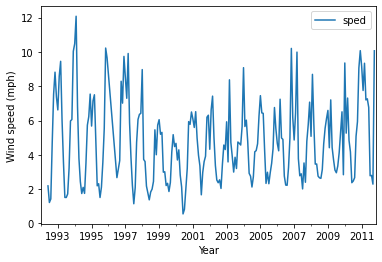

In [20]:
def plot_ts(sid):
    df[df["station"] == sid].groupby("my").mean().reset_index().plot(
        x="my", 
        y="sped", 
        xlabel="Year", 
        ylabel="Wind speed (mph)"
    )
    plt.show()
    
    return None

plot_ts("PAJV")

Looks like this station hasn't reported in 10 years. However, it has a sufficient record length to warrant keeping it. Rename and include the runway info.

In [21]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PALV"], 
        "rw_name": ["Runway 3/21"], 
        "rw_heading": [np.nan],
        "faa_id": ["JVM"],
        "real_name": "Jonesville Mine Airport",
    }),
)

#### PAHZ

Hayes River Airport. Could not find any runway info. Monthly timeseries:

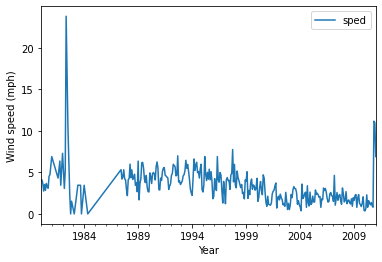

In [22]:
plot_ts("PAHZ")

Again, another station that has no reports in 10 years, but a sufficient amount of data to warrant keeping it. Visible spikes that need to be evaluated.

In [23]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PAHZ"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["HZZ"],
        "real_name": "Hayes River Airport",
    }),
)

#### PAEC

Chulitna Airport. Not sure if this is an actual airport, not much info on it. Monthly time series:

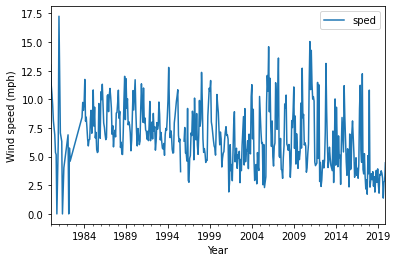

In [24]:
plot_ts("PAEC")

In [25]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PAEC"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["AEC"],
        "real_name": "Chulitna",
    }),
)

#### PAPT

Believe this is near [Rainy Pass Lodge Airport](https://www.airnav.com/airport/6AK), could even be on premises, but will still call Puntilla Lake for now. Will omit runway information for Rainy Pass Lodge Airport. 

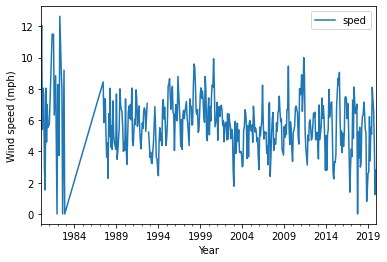

In [26]:
plot_ts("PAPT")

In [27]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PAPT"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["PTI"],
        "real_name": "Puntilla Lake",
    }),
)

#### PALV

Big River Lakes, no other info. 

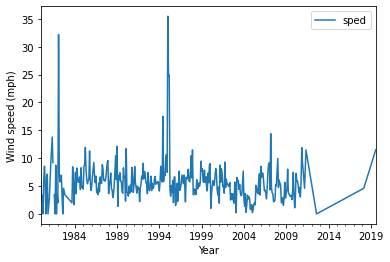

In [28]:
plot_ts("PALV")

In [29]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PALV"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["LVR"],
        "real_name": "Big River Lakes",
    }),
)

#### PATO

Believe this is not an airport, probably at the Begich Boggs Visitor Center? 

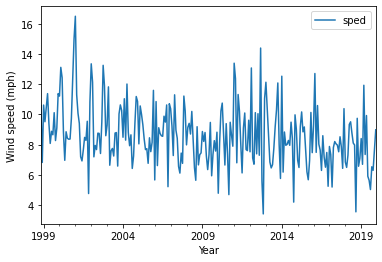

In [30]:
plot_ts("PATO")

In [31]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PATO"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["POR"],
        "real_name": "Begich Boggs Visitor Center",
    }),
)

#### PAVW

Valdez Weather Service Office.

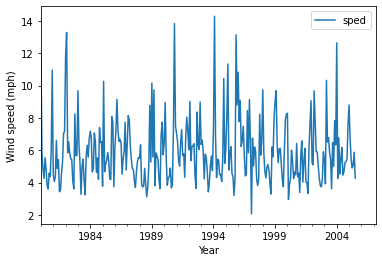

In [32]:
plot_ts("PAVW")

In [33]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PAVW"], 
        "rw_name": [np.nan], 
        "rw_heading": [np.nan],
        "faa_id": ["VWS"],
        "real_name": "Valdez Weather Service Office",
    }),
)

#### PAZK

Skelton Airport. At [AirNav](https://www.airnav.com/airport/3AK1) under FAA identifier: 3AK1.

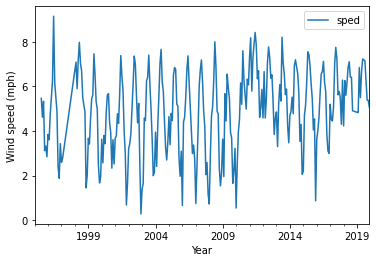

In [34]:
plot_ts("PAZK")

In [35]:
new_meta = new_meta.append(
    pd.DataFrame({
        "sid": ["PAZK"], 
        "rw_name": ["Runway 3/21"], 
        "rw_heading": [np.nan],
        "faa_id": ["3AK1"],
        "real_name": "Skelton Airport",
    }),
)

In [36]:
# save new meta to data/meta_amend.csv
new_meta.to_csv("../data/meta_amend.csv", index=False)
# save stations to ignore
pd.DataFrame({"sid": discard}).to_csv(base_dir.joinpath("discard.csv"), index=False)

## Filtering erroneous data (spikes/dips)

This section is for developing a method to identify and remove spikes/dips from the raw data. 

Previous efforts to remove spurious spikes and dips from these IEM data have relied on a fixed delta threshold method: an observation is flagged a spurious if the magnitude of the delta between the observation and both neighboring (preceding and following) observations is greater than some fixed value. This threshold was 30 mph for the data used in the community winds tool. 

While this method did filter out most spurious observartions, we found that it had a number of false positives, and show here that there are false negatives that couled be avoided, too. This section uses the spikes at a couple of exapmle locations, Fairbanks and Nome, to try to improve this spike detection method. 

### Spikes

Here are the spikes identified for Nome under the original method:

In [37]:
def get_spikes_original(station):
    def remove_subsequent_idx(idx):
        k = idx[0]
        r = []
        for i in np.arange(idx[1:].shape[0]):
            if (idx[i + 1] - k) == 1:
                r.append(i + 1)
            k = idx[i + 1]

        return idx[np.array(r)]

    station = station.copy()
    station = station.reset_index()
    xname = "sped"
    tname = "valid"
    delta = 30

    # speed deltas
    xd = abs(station[xname].values[1:] - station[xname].values[:-1])
    # time deltas
    td = (station[tname].values[1:] - station[tname].values[:-1]) / (10 ** 9 * 3600)
    # potential spikes
    pidx = np.where(xd > delta)[0]
    # true spike indices (time difference of two hours or less)
    try:
        sidx = remove_subsequent_idx(pidx[td[pidx].astype(float) <= 2])
    except IndexError:
        sidx = pidx
    spikes = pd.DataFrame(station.take(sidx))
    
    return spikes


paom = pd.read_csv(list(base_dir.joinpath("raw/iem").glob("*PAOM*"))[0], na_values="M")
paom["valid"] = pd.to_datetime(paom["valid"])
paom = paom.set_index("valid")

spikes = get_spikes_original(paom)
spikes.set_index("valid").drop(columns=["station", "drct", "gust_mph"])

,sped
valid,
1980-01-05 21:00:00,51.75
1980-03-10 19:00:00,63.25
1980-05-04 20:00:00,55.20
1980-07-31 13:00:00,63.30
1981-01-16 16:00:00,63.30
1981-07-27 11:00:00,57.50
1981-10-24 05:08:00,58.65
1982-01-29 23:14:00,64.40
1982-02-04 23:44:00,43.70


And here are the spikes for Fairbanks:

In [38]:
pafa = pd.read_csv(list(base_dir.joinpath("raw/iem").glob("*PAFA*"))[0], na_values="M")
pafa["valid"] = pd.to_datetime(pafa["valid"])
pafa = pafa.set_index("valid")

spikes = get_spikes_original(pafa)
spikes.set_index("valid").drop(columns=["station", "drct", "gust_mph"])

,sped
valid,
1980-12-15 12:00:00,57.50
1981-04-08 02:00:00,50.60
1981-09-30 12:00:00,48.30
1982-12-02 11:11:00,48.30
1987-12-21 22:01:00,54.05
2002-10-08 22:53:00,140.30
2013-03-14 12:53:00,128.80


As mentioned above, the goal is to improve both the false positive and false negative error rates. There is greater potential for false positives during higher wind periods, because higher winds are typically associated with larger swings in winds, which renders the fixed 30mph threshold less effective during these times. Similarly, The fixed threshold of 30 mph may be too large during calm periods, where jumps of 20 mph or so are highly suspect.  

A good example of the former is the record at 2011-11-09 11:53:00 at Nome Airport which was flagged:

In [39]:
paom["2011-11-09 05:53:00" :"2011-11-09 12:00:00"]

,station,sped,drct,gust_mph
valid,,,,
2011-11-09 05:53:00,PAOM,44.85,100.0,60.95
2011-11-09 05:53:00,PAOM,44.85,100.0,60.95
2011-11-09 05:53:00,PAOM,44.85,100.0,60.95
2011-11-09 09:53:00,PAOM,40.25,120.0,55.20
2011-11-09 11:53:00,PAOM,73.77,140.0,93.89
2011-11-09 12:00:00,PAOM,37.95,130.0,49.45
2011-11-09 12:00:00,PAOM,37.95,130.0,49.45


This is not a spurious spike, and is therefore an important record to include given its manitude!

The method also misses observations that could be spurious but not as severe, and one such observation that is likely a false negative is 1997-12-10 03:53:00:

In [40]:
paom["1997-12-10 01:00:00" :"1997-12-10 06:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1997-12-10 01:50:00,PAOM,12.65,340.0,NaN
1997-12-10 02:57:00,PAOM,13.80,330.0,NaN
1997-12-10 03:53:00,PAOM,37.95,330.0,NaN
1997-12-10 04:55:00,PAOM,11.50,330.0,NaN
1997-12-10 05:50:00,PAOM,11.50,330.0,NaN


Unfortunately there is no original scanned record to check this against. 

Here is an example of a spurious observation that was missed at Fairbanks, at 1982-05-21 18:35:00:

In [41]:
pafa["1982-05-21 17:00:00": "1982-05-21 20:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1982-05-21 17:00:00,PAFA,6.90,240.0,NaN
1982-05-21 18:00:00,PAFA,11.50,230.0,NaN
1982-05-21 18:35:00,PAFA,40.25,180.0,NaN
1982-05-21 19:00:00,PAFA,10.35,220.0,NaN
1982-05-21 20:00:00,PAFA,12.65,250.0,NaN


Review of the original [METARs](swo/pafa_swo_19820521.pdf) show that this is an error in digitizing, and the real speed was actually 9 kts (10.35 mph). These examples demonstrate the need for a more sensitive method of spike detection. 

After some experimentation with manually implementing some statistical methods, the most straightforward solution at this time appears to be enlisting the help of external code. `scipy.signal.find_peaks` appears to perform well with the correct parameter specification. Here are the spikes detected at Nome Airport using this function with `prominence=25`:

In [42]:
# example of conditioning peaks on width_heights property being >= 18
# for Nome to avert false positive

# without conditioning on width_heights being >= 18

ws_series = paom[~np.isnan(paom["sped"])]["sped"]
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))

pd.DataFrame(ws_series[peaks])

,sped
valid,
1980-01-05 21:00:00,51.75
1980-01-14 17:00:00,25.30
1980-03-10 19:00:00,63.25
1980-05-04 20:00:00,55.20
1980-07-31 13:00:00,63.30
1981-01-16 16:00:00,63.30
1981-02-13 12:00:00,29.90
1981-07-27 11:00:00,57.50
1981-10-24 05:08:00,58.65


Whoa! This flagged many more records thatn the original. We see no false positive at 2011-11-09, and the likely false negative at 1997-12-10 is captured, which are good signs. However, this algorithm may be oversensitive to smaller deviations, e.g. at 1980-01-14 17:00:00, 1981-02-13 12:00:00, etc. Are these actually spurious?

In [43]:
paom["1980-01-14 15:00:00" :"1980-01-14 19:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1980-01-14 15:00:00,PAOM,11.50,350.0,23.0
1980-01-14 16:00:00,PAOM,5.75,280.0,NaN
1980-01-14 17:00:00,PAOM,25.30,330.0,NaN
1980-01-14 18:00:00,PAOM,11.50,350.0,NaN
1980-01-14 19:00:00,PAOM,13.80,340.0,NaN


Doesn't look like it, and the original [METARs](swo/paom_swo_19800114.pdf) confirm this is a valid record. How about 1981-02-13 12:00:00?

In [44]:
paom["1981-02-13 10:00:00" :"1981-02-13 14:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1981-02-13 10:00:00,PAOM,17.25,350.0,NaN
1981-02-13 11:00:00,PAOM,10.35,50.0,NaN
1981-02-13 12:00:00,PAOM,29.90,10.0,34.5
1981-02-13 13:00:00,PAOM,13.80,30.0,NaN
1981-02-13 14:00:00,PAOM,12.65,40.0,NaN


Again, METARs [METARs](swo/paom_swo_19810213.pdf) confirm this is a valid record.

Here are the peaks detected for Fairbanks Intl Airport using this function, and this same issue of false positives is evident:

In [45]:
ws_series = pafa[~np.isnan(pafa["sped"])]["sped"]
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))

pd.DataFrame(ws_series[peaks])

,sped
valid,
1980-06-20 19:00:00,32.20
1980-07-19 23:00:00,27.60
1980-12-15 12:00:00,57.50
1981-04-08 02:00:00,50.60
1981-06-16 00:13:00,29.90
1981-09-30 12:00:00,48.30
1982-05-21 18:35:00,40.25
1982-12-02 11:11:00,48.30
1986-08-28 05:01:00,26.45


How about the first two spikes, at 1980-06-20 19:00:00 and 1980-07-19 23:00:00?

In [46]:
pafa["1980-06-20 17:00:00": "1980-06-20 21:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1980-06-20 17:00:00,PAFA,0.0,0.0,NaN
1980-06-20 18:00:00,PAFA,6.9,210.0,NaN
1980-06-20 19:00:00,PAFA,32.2,190.0,NaN
1980-06-20 20:00:00,PAFA,11.5,170.0,NaN
1980-06-20 21:00:00,PAFA,6.9,100.0,NaN


This looks legit, and the [METARs](swo/pafa_swo_19800620.pdf) agree. 

In [47]:
pafa["1980-07-19 21:00:00": "1980-07-20 01:00:00"]

,station,sped,drct,gust_mph
valid,,,,
1980-07-19 21:00:00,PAFA,3.45,110.0,NaN
1980-07-19 22:00:00,PAFA,8.05,190.0,NaN
1980-07-19 23:00:00,PAFA,27.60,360.0,NaN
1980-07-20 00:00:00,PAFA,9.20,160.0,NaN
1980-07-20 01:00:00,PAFA,5.75,320.0,NaN


This one looks a little more suspicious, but the [METARs](swo/pafa_swo_19800719.pdf) again indicate it is a valid record. These examples show the greater susceptibility of this method to signaling false positives. 

Luckily, some tinkering has revealed that conditioning on the properties of the peak (returned from the function) can eliminate these false positives. Specifically, conditioning on the `width_heights` property being >= 18 seems to be the sweet spot for these two locations.

Here are the spikes for Nome and Fairbanks after conditioning on this property:

In [48]:
print("Nome Airport:")
ws_series = paom[~np.isnan(paom["sped"])]["sped"]
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))

pd.DataFrame(ws_series[peaks[properties["width_heights"] >= 18]])

Nome Airport:


,sped
valid,
1980-01-05 21:00:00,51.75
1980-03-10 19:00:00,63.25
1980-05-04 20:00:00,55.20
1980-07-31 13:00:00,63.30
1981-01-16 16:00:00,63.30
1981-07-27 11:00:00,57.50
1981-10-24 05:08:00,58.65
1982-01-29 23:14:00,64.40
1982-02-04 23:44:00,43.70


In [49]:
print("Fairbanks Intl Airport:")
ws_series = pafa[~np.isnan(pafa["sped"])]["sped"]
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))

pd.DataFrame(ws_series[peaks[properties["width_heights"] >= 18]])

Fairbanks Intl Airport:


,sped
valid,
1980-12-15 12:00:00,57.50
1981-04-08 02:00:00,50.60
1981-09-30 12:00:00,48.30
1982-05-21 18:35:00,40.25
1982-12-02 11:11:00,48.30
1987-12-21 22:01:00,54.05
2002-10-08 22:53:00,140.30
2013-03-14 12:53:00,128.80


The false positives identified above are all now absent from these peaks, and the original false negative example at Nome Airport 1997-12-10 03:53:00 was picked up. Additionally, a new false negative for Fairbanks Intl Airport was identified, the record at 1982-05-21 18:35:00, as verified by the [METARs](swo/pafa_swo_19820521.pdf) for that day. 

### Dips

Another repeating artifact of the IEM ASOS wind speed data is the potential for dips, particularly instances where the reported wind speed dips to zero or near zero during a period of high winds. It looks like the `scipy.signal.find_peaks` function could be used to detect these by inverting the time series. First, here is an example of the issue at Tin City (PATC):

In [50]:
patc = pd.read_csv(list(base_dir.joinpath("raw/iem").glob("*PATC*"))[0], na_values="M")
patc["valid"] = pd.to_datetime(patc["valid"])
patc = patc.set_index("valid")

patc["1999-03-25"]

,station,sped,drct,gust_mph
valid,,,,
1999-03-25 00:55:00,PATC,32.20,10.0,NaN
1999-03-25 01:55:00,PATC,35.65,10.0,39.10
1999-03-25 02:55:00,PATC,31.05,10.0,NaN
1999-03-25 04:55:00,PATC,36.80,20.0,40.25
1999-03-25 05:55:00,PATC,39.10,20.0,NaN
1999-03-25 06:55:00,PATC,40.25,10.0,NaN
1999-03-25 07:55:00,PATC,43.70,10.0,NaN
1999-03-25 08:55:00,PATC,39.10,10.0,NaN
1999-03-25 09:55:00,PATC,41.40,10.0,NaN


All the zeros in that slice are highly likely to be spurious. By inverting the time series and running the peak detection function on these, it looks like we can do a decent job of identifying the dips:

In [51]:
# testing dip detection by inverting series
ws_series = patc[~np.isnan(patc["sped"])]["sped"]
# filter out obs > 110 mph
ws_series = ws_series[ws_series < 110] * -1

# ignore PeakProper
#with warnings.catch_warnings():
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 5), threshold=30)

ws_series[peaks]

valid
1994-05-12 06:35:00    -1.15
1996-12-03 18:55:00    -0.00
1996-12-09 12:55:00    -3.45
1997-02-11 09:55:00    -0.00
1997-12-05 01:55:00    -0.00
1998-01-10 05:55:00    -0.00
1998-02-06 15:55:00    -0.00
1998-02-06 20:55:00    -0.00
1998-02-06 22:55:00    -0.00
1998-02-07 01:55:00    -0.00
1998-03-14 19:55:00    -0.00
1998-03-14 22:55:00    -0.00
1998-04-17 10:55:00    -0.00
1998-05-06 09:55:00    -0.00
1998-05-06 15:55:00    -0.00
1999-02-17 00:55:00    -0.00
1999-02-17 03:55:00    -0.00
1999-03-24 09:55:00    -0.00
1999-03-25 13:55:00    -0.00
1999-03-25 17:55:00    -0.00
1999-03-25 19:55:00    -0.00
1999-03-25 22:55:00    -0.00
1999-03-26 02:55:00    -0.00
1999-04-11 05:55:00    -0.00
2000-01-18 03:15:00    -0.00
2000-01-18 13:55:00    -0.00
2000-01-18 15:35:00    -0.00
2011-11-09 15:37:00   -35.65
2013-03-07 02:35:00   -29.90
2013-06-07 15:55:00   -11.50
2013-12-09 14:55:00   -27.60
2014-01-22 19:43:00    -3.45
Name: sped, dtype: float64

Note: to more easily identify dips, obviously spurious observations were removed first. The cutoff chosen is 110 mph, because 100mph, the previous cutoff, may actually be possible at some locations.

Looks like this successfully identifies the dips identified in the example above. But there are couple of issues: what about 2013-06-07, where the "dip" is at 11.5 mph? See below, these are dips caused by the spikes! 

In [52]:
patc["2013-06-07 03:45:00": "2013-06-07 18:00:00"].drop(columns="gust_mph").dropna()

,station,sped,drct
valid,,,
2013-06-07 03:45:00,PATC,23.00,190.0
2013-06-07 03:55:00,PATC,24.15,190.0
2013-06-07 04:55:00,PATC,87.40,80.0
2013-06-07 15:55:00,PATC,11.50,330.0
2013-06-07 16:23:00,PATC,87.40,130.0
2013-06-07 16:54:00,PATC,11.50,360.0
2013-06-07 17:50:00,PATC,24.15,170.0
2013-06-07 17:55:00,PATC,17.25,170.0


Given the potential for spikes to be more evident (no upper bound), the best thing to do is probably a 3-step process: 
1. remove the obvious spikes with strict, threshold-based peak detection criteria
2. remove the dips by inverting the series, 
3. remove the less obvious spikes

Here is the same slice of the time series after the complete peak detection and removal algo:

In [53]:
# testing dip detection by inverting series
ws_series = patc[~np.isnan(patc["sped"])]["sped"]
# filter out obs > 110 mph
ws_series = ws_series[ws_series < 110]
# remove obvious spikes
obv_peaks, _ = find_peaks(ws_series, prominence=30, threshold=50)
ws_series = ws_series.drop(ws_series.index[obv_peaks])
# invert series, identify dips using less strict criteria
dips, _ = find_peaks(ws_series * -1, prominence=30, threshold=35)
ws_series = ws_series.drop(ws_series.index[dips])
# idenitfy spikes using less strict criteria
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))
ws_series = ws_series.drop(ws_series.index[peaks[properties["width_heights"] > 18]])

ws_series["2013-06-07 03:45:00": "2013-06-07 18:00:00"]

valid
2013-06-07 03:45:00    23.00
2013-06-07 03:55:00    24.15
2013-06-07 15:55:00    11.50
2013-06-07 16:54:00    11.50
2013-06-07 17:50:00    24.15
2013-06-07 17:55:00    17.25
Name: sped, dtype: float64

And here is the example time series used above to demonstrate the dips:

In [54]:
ws_series["1999-03-25"]

valid
1999-03-25 00:55:00    32.20
1999-03-25 01:55:00    35.65
1999-03-25 02:55:00    31.05
1999-03-25 04:55:00    36.80
1999-03-25 05:55:00    39.10
1999-03-25 06:55:00    40.25
1999-03-25 07:55:00    43.70
1999-03-25 08:55:00    39.10
1999-03-25 09:55:00    41.40
1999-03-25 11:55:00    42.55
1999-03-25 13:04:00    43.70
1999-03-25 15:55:00    37.95
1999-03-25 16:55:00    43.70
1999-03-25 18:55:00    41.40
1999-03-25 20:55:00    44.85
1999-03-25 21:55:00    43.70
1999-03-25 23:55:00    43.70
Name: sped, dtype: float64

Looking good. Double check that this performs well with the other example stations, Nome and Fairbanks, by printing the observations that are identified as spurious using this complete approach. 

#### Nome

Obvious spikes:

In [55]:
# testing dip detection by inverting series
ws_series = paom[~np.isnan(paom["sped"])]["sped"]
# filter out obs > 110 mph
ws_series = ws_series[ws_series < 110]
# remove obvious spikes
obv_peaks, _ = find_peaks(ws_series, prominence=30, threshold=50)
spikes = ws_series[obv_peaks]
ws_series = ws_series.drop(spikes.index)
# invert series, identify dips using less strict criteria
dips, _ = find_peaks(ws_series * -1, prominence=30, threshold=35)
try:
    dips = ws_series[dips]
    ws_series = ws_series.drop(dips.index)
except:
    None
# idenitfy spikes using less strict criteria
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))
peaks = peaks[properties["width_heights"] > 18]

spikes

valid
1980-03-10 19:00:00     63.25
1980-07-31 13:00:00     63.30
2003-04-15 20:53:00    102.35
Name: sped, dtype: float64

Dips:

In [56]:
dips

Series([], Name: sped, dtype: float64)

Less prominent spikes:

In [57]:
ws_series[peaks]

valid
1980-01-05 21:00:00    51.75
1980-05-04 20:00:00    55.20
1981-01-16 16:00:00    63.30
1981-07-27 11:00:00    57.50
1981-10-24 05:08:00    58.65
1982-01-29 23:14:00    64.40
1982-02-04 23:44:00    43.70
1997-12-10 03:53:00    37.95
Name: sped, dtype: float64

#### Fairbanks

Obvious spikes:

In [58]:
# testing dip detection by inverting series
ws_series = pafa[~np.isnan(pafa["sped"])]["sped"]
# filter out obs > 110 mph
ws_series = ws_series[ws_series < 110]
# remove obvious spikes
obv_peaks, _ = find_peaks(ws_series, prominence=30, threshold=50)
spikes = ws_series[obv_peaks]
ws_series = ws_series.drop(spikes.index)
# invert series, identify dips using less strict criteria
dips, _ = find_peaks(ws_series * -1, prominence=30, threshold=35)
try:
    dips = ws_series[dips]
    ws_series = ws_series.drop(dips.index)
except:
    None
# idenitfy spikes using less strict criteria
peaks, properties = find_peaks(ws_series, prominence=25, width=(None, 2))
peaks = peaks[properties["width_heights"] > 18]

spikes

valid
1980-12-15 12:00:00    57.5
Name: sped, dtype: float64

Dips:

In [59]:
dips

Series([], Name: sped, dtype: float64)

Less obvious spikes:

In [60]:
ws_series[peaks]

valid
1981-04-08 02:00:00    50.60
1981-09-30 12:00:00    48.30
1982-05-21 18:35:00    40.25
1982-12-02 11:11:00    48.30
1987-12-21 22:01:00    54.05
Name: sped, dtype: float64

So no dips were identified for Fairbanks or Nome and that is OK. It looks like the 3-step spike detection algorithm identified the same spikes found with the single step algorithm developed above that did not account for dips. 

Given time constraints on the project, this will have to serve as sufficient evidence that this implementation of the `scipy.signal.find_peaks` function for identifying spikes and dips for removal, while not perfect, is defensible.